## Initialisation + EDA

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [2]:
data = pd.read_csv('conversion_data_train.csv')

In [3]:
data.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,59203,59203.000000,59203.000000,59203,59203.000000,59202.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,33371,NaN,NaN,28834,NaN,NaN
mean,NaN,30.595578,0.685438,NaN,4.880580,0.032246
std,NaN,8.244437,0.464345,NaN,3.355812,0.176653
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59203 entries, 0 to 59202
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              59203 non-null  object 
 1   age                  59203 non-null  int64  
 2   new_user             59203 non-null  int64  
 3   source               59203 non-null  object 
 4   total_pages_visited  59203 non-null  int64  
 5   converted            59202 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.7+ MB


In [5]:
# suppression de la ligne contenant un nan dans la colonne converted
data = data.dropna(axis=0)

In [6]:
# Check si nous avons bien maintenant 59202 rows
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59202 entries, 0 to 59201
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              59202 non-null  object 
 1   age                  59202 non-null  int64  
 2   new_user             59202 non-null  int64  
 3   source               59202 non-null  object 
 4   total_pages_visited  59202 non-null  int64  
 5   converted            59202 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 3.2+ MB


In [7]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0.0
1,UK,21,1,Ads,3,0.0
2,Germany,20,0,Seo,14,1.0
3,US,23,1,Seo,3,0.0
4,US,28,1,Direct,3,0.0


In [8]:
# Supprimer les outliers de AGE

cols = ['age'] # one or more
Q1 = data[cols].quantile(0.25)
Q3 = data[cols].quantile(0.75)
intervalle = Q3 - Q1

data = data[~((data[cols] < (Q1 - 1.5 * intervalle)) |(data[cols] > (Q3 + 1.5 * intervalle))).any(axis=1)]
#data.describe(include='all')

In [9]:
# # Supprimer les outliers de 'total_pages_visited'
# PAS BON DU TOUT. m'a fait tomber à 0.49.

# cols = ['total_pages_visited'] # one or more
# Q1 = data[cols].quantile(0.25)
# Q3 = data[cols].quantile(0.75)
# intervalle = Q3 - Q1

# data = data[~((data[cols] < (Q1 - 1.5 * intervalle)) |(data[cols] > (Q3 + 1.5 * intervalle))).any(axis=1)]
# data.describe(include='all')

In [10]:
# On va doper total_pages_visited
data['total_pages_visited_sq'] = (data['total_pages_visited']**2)
#data['age_sq'] = (data['age']**2) # M'a fait retomber à 0.75550195960205
#data = data.drop('total_pages_visited', axis=1)
display(data.head())

,country,age,new_user,source,total_pages_visited,converted,total_pages_visited_sq
0,China,22,1,Direct,2,0.0,4
1,UK,21,1,Ads,3,0.0,9
2,Germany,20,0,Seo,14,1.0,196
3,US,23,1,Seo,3,0.0,9
4,US,28,1,Direct,3,0.0,9


# Régression logistique multivariée
On peut appliquer ce modèle car il s'agit de prédire une variable catégorielle (converted).

In [11]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "converted"

X = data.drop(target_variable, axis = 1)
Y = data.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    0.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: converted, dtype: float64

X :
   country  age  new_user  source  total_pages_visited  total_pages_visited_sq
0    China   22         1  Direct                    2                       4
1       UK   21         1     Ads                    3                       9
2  Germany   20         0     Seo                   14                     196
3       US   23         1     Seo                    3                       9
4       US   28         1  Direct                    3                       9


In [12]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'new_user', 'total_pages_visited', 'total_pages_visited_sq']
Found categorical features  ['country', 'source']


<ipython-input-12-0f0a515c43b5>:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i,t in X.dtypes.iteritems():


In [13]:
# Divide dataset Train set & Test set
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [14]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Inutile ici mais peut être utile sur un nouveau dataset où des nan seraient plus nombreux
    ('scaler', StandardScaler())
])

In [15]:
# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first') # no missing values in categorical data, so we only need the OHE

In [16]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [17]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_train.head())
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")
print(Y_train[0:5])

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_test[0:5])
Y_test = encoder.transform(Y_test)
print("...Done")
print(Y_test[0:5])

Performing preprocessings on train set...
      country  age  new_user  source  total_pages_visited  \
736        US   21         1  Direct                    6   
54769      UK   48         0     Seo                    1   
13568      US   19         0     Seo                   11   
670        US   18         0     Seo                    2   
57992      US   28         1  Direct                    2   

       total_pages_visited_sq  
736                        36  
54769                       1  
13568                     121  
670                         4  
57992                       4  
...Done.
[[-1.17829564  0.67767824  0.3341416   0.01701247  0.          0.
   1.          1.          0.        ]
 [ 2.17437386 -1.47562655 -1.15184633 -0.64021345  0.          1.
   0.          0.          1.        ]
 [-1.42664153 -1.47562655  1.82012954  1.61313255  0.          0.
   1.          0.          1.        ]
 [-1.55081448 -1.47562655 -0.85464874 -0.5838798   0.          0.
   1.    

In [18]:
# Train model
print("Train model...")
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [19]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = classifier.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[0 0 0 ... 1 0 0]

Probabilities on training set...
...Done.
[[9.97666256e-01 2.33374408e-03]
 [9.99888225e-01 1.11775234e-04]
 [5.46245469e-01 4.53754531e-01]
 ...
 [1.23408725e-01 8.76591275e-01]
 [9.99981100e-01 1.88996691e-05]
 [9.92957988e-01 7.04201194e-03]]



In [20]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = classifier.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on test set...
...Done.
[[9.94204442e-01 5.79555770e-03]
 [9.99970056e-01 2.99443102e-05]
 [9.99988374e-01 1.16258221e-05]
 ...
 [9.98664378e-01 1.33562231e-03]
 [9.97987169e-01 2.01283078e-03]
 [9.99827853e-01 1.72146519e-04]]



In [21]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.9864873464712246
accuracy on test set :  0.9854912608179196

f1-score on training set :  0.7676030645749726
f1-score on test set :  0.7510917030567685



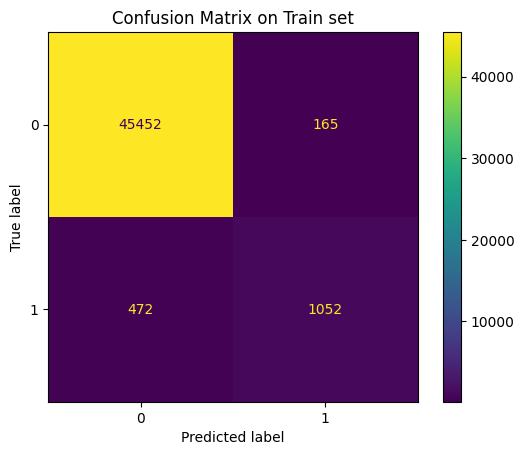

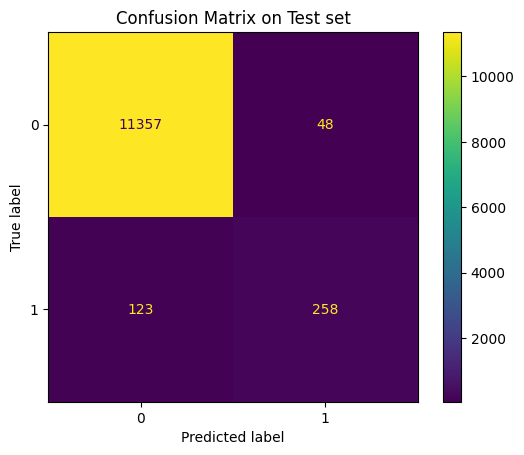

In [22]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

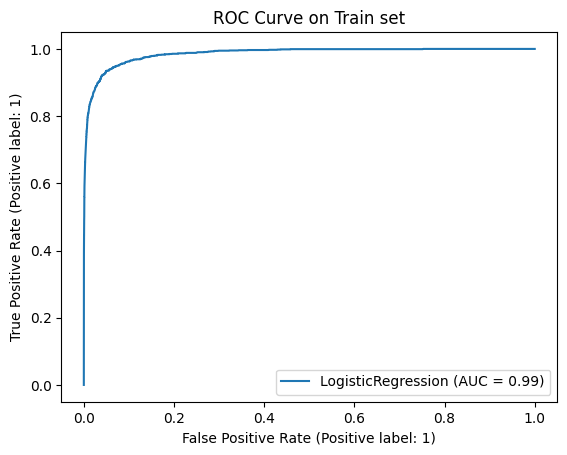

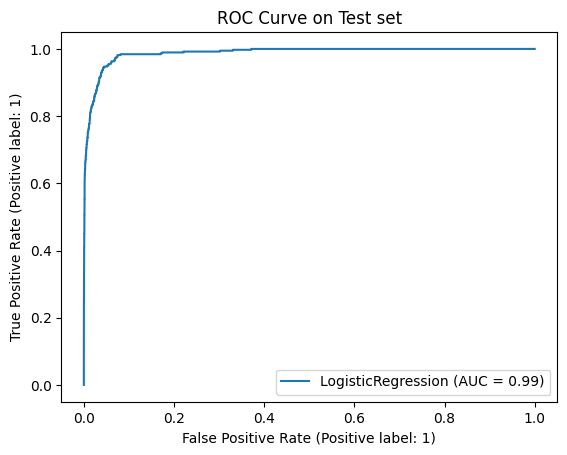

In [23]:
# Visualize ROC curves
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # RocCurveDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()

In [24]:
# Meilleur score
# accuracy on training set :  0.9861057166060521
# accuracy on test set :  0.9863707783839133

# f1-score on training set :  0.7618038740920097
# f1-score on test set :  0.7687237866986218

In [25]:
# Print F1-score

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.9864873464712246
accuracy on test set :  0.9854912608179196

f1-score on training set :  0.7676030645749726
f1-score on test set :  0.7510917030567685



# Conclusion

Pour rappel :
* la baseline a été effectuée sur une régression linéaire, sur la seule feature *total_pages_visited*,
* Ce notebook expose une régression logistique multivariée prenant en compte toutes les features,
* Fine tuning : Ajout d'une feature total_pages_visited_sq dans laquelle je monte au carré la feature total_pages_visited.

## Comparatif des résultats (Metric : F1-score)

**BASELINE**

*   f1-score on train set :  0.6938517686692869
*   f1-score on test set :  0.7060240963855423

**REGRESSION LOGISTIQUE MULTIVARIEE**

*   f1-score on train set :  0.7676030645749726
*   f1-score on test set :  0.7510917030567685



En intégrant désormais toutes les features, nous avons augmenté le F1-score sur le test set. Cela signifie que cette régression logistique multivariée est plus efficace et performante que la simple baseline. Il était donc utile de rajouter ces autres features pour améliorer les scores et la généralisation du modèle.